In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from os import path, makedirs
from json import load
from collections import Counter, defaultdict
from utils import reorder_matrix
from matplotlib.ticker import PercentFormatter

In [3]:
plt.rcParams['font.family'] = "sans-serif"

# Load data

In [4]:
documents_toIgnore = ['adidas AG', 'AstraZeneca PLC', 'British American Tobacco PLC', 'PepsiCo Inc']

## Fiscal years of the companies

In [5]:
with open(path.join('..', 'outputs', 'genSRL', 'clustered_t80', 'triples_wizardLM_filtering.json')) as json_file:
    triples = load(json_file)

# Retrieve the fiscal year of the company
company_fiscalYears = dict()
for company, company_triples in triples.items():
    
    if company in documents_toIgnore:
        continue
    
    fiscal_years = [triple['properties']['source'].split('-')[0] for triple in company_triples]
    fiscal_years = Counter(fiscal_years).most_common(5)
    
    if len(fiscal_years) == 1:
        company_fiscalYears[company.lower()] = int(fiscal_years[0][0])
    else:
        raise Exception(f'The company {company} has more than one fiscal year: {fiscal_years}')

company_fiscalYears = dict(sorted(company_fiscalYears.items(), key = lambda dict_item: dict_item[1], reverse = True))
display(company_fiscalYears)
print('Number of companies:', len(company_fiscalYears))

{'3m corporation': 2022,
 '3i group plc': 2022,
 'alcon inc': 2022,
 'alibaba group holding limited': 2022,
 'alphabet inc': 2022,
 'american electric power company inc': 2022,
 'apple inc': 2022,
 'british land co plc the': 2022,
 'builders firstsource inc': 2022,
 'campbell soup company': 2022,
 'canon inc': 2022,
 'carmax inc': 2022,
 'commonwealth bank of australia': 2022,
 'daikin industries ltd': 2022,
 'dupont': 2022,
 'fedex corporation': 2022,
 'fox corporation': 2022,
 'franklin electric co inc': 2022,
 'geely automobile holdings ltd': 2022,
 'globalfoundries': 2022,
 'home depot inc the': 2022,
 'hyundai motor co': 2022,
 'imperial oil ltd': 2022,
 'iveco group nv': 2022,
 'kia corp': 2022,
 'korean air lines co ltd': 2022,
 'kraft heinz co the': 2022,
 'lg display co ltd': 2022,
 'nvidia corp': 2022,
 'novo nordisk a s': 2022,
 'paramount resources ltd': 2022,
 'stmicroelectronics': 2022,
 'samsung electronics co ltd': 2022,
 'skywest inc': 2022,
 'snam spa': 2022,
 'sony c

Number of companies: 124


,counter
2015,0.008065
2016,0.008065
2017,0.008065
2018,0.008065
2019,0.016129
2020,0.129032
2021,0.500000
2022,0.322581


,counter
2015-2019,0.048387
2020,0.129032
2021,0.500000
2022,0.322581


,2015-2019,2020,2021,2022
counter,0.048387,0.129032,0.5,0.322581


<Figure size 2000x300 with 0 Axes>

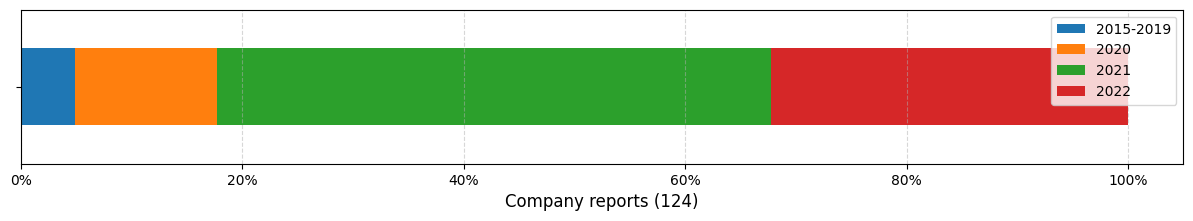

In [143]:
from tkinter import font


fiscalYears_df = pd.Series(Counter(company_fiscalYears.values())).rename('counter').sort_index(ascending=True).to_frame()
fiscalYears_df /= fiscalYears_df.sum()
display(fiscalYears_df)
to_aggregate = [2015, 2016, 2017, 2018, 2019]

fiscalYears_df = pd.concat([pd.Series(fiscalYears_df.loc[to_aggregate, 'counter'].sum(), index = [f'{to_aggregate[0]}-{to_aggregate[-1]}'], name = 'counter').to_frame(), fiscalYears_df])
fiscalYears_df = fiscalYears_df.drop(index = to_aggregate)
display(fiscalYears_df)
fiscalYears_df= fiscalYears_df.T
display(fiscalYears_df)

plt.figure(figsize=(20, 3))
#sns.barplot(hue = fiscalYears_df.index, x = fiscalYears_df['counter'], orient = 'h', palette='Paired', dodge = False) 
fiscalYears_df.plot.barh(stacked=True, figsize=(15, 2))
plt.xlabel('Company reports (124)', fontsize = 12)
#plt.ylabel('Fiscal year',  fontsize = 12)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals = 0))
plt.grid(True, axis = 'x', linestyle = '--', alpha = 0.5)
plt.yticks(visible=False)
plt.savefig('fiscalYears_distribution.pdf', bbox_inches='tight')
plt.show()

In [ ]:
df = pd.read_excel(path.join('..', 'data', 'esgScores.xlsx'), parse_dates = ['Date of Incorporation', 'Date Became Public'])

# Parse the fiscal year
df['Financial Period'] = df['Financial Period'].str.replace('FY', '').astype(pd.Int32Dtype())
df['ESG Financial Period'] = df['ESG Financial Period'].str.replace('FY', '').astype(pd.Int32Dtype())

# Rename the column
df.rename(columns={'Company': 'Dataset Company Name'}, inplace=True) # 'ESG Financial Period': 'Fiscal Year', 

# Insert a normalised name column
df.insert(loc = 0, column = 'Company', value = df['Dataset Company Name'].str.lower())

df.drop(columns = ['Region of Headquarters'], inplace = True)

# Remove the rows with no fiscal year
df = df.dropna(subset=['ESG Financial Period'])

display(df)

# Compute the embeddings

In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings, DeterministicFakeEmbedding

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm

In [ ]:

def logicsticTransformation(df, verbose = True):
    
    transformed_df = df.copy()
    
    for col in df.columns:
        
        normalised_value = lambda value: (value - df[col].min()) / (df[col].max() - df[col].min()) 
        # .map(lambda x: x if x > 0 else 0)
        
        # Define the model
        lm = sm.GLM(
            endog = df[col].map(lambda x: x if x > 0 else 0),
            exog = df[col], 
            family = sm.families.Binomial(link = sm.families.links.Probit()))

        #lm = sm.Logit(endog = df[col].map(normalised_value), exog = df[col])
        
        # Fit the model
        lm_results = lm.fit()
        lm_results = lm.fit_constrained('coeff > 0')
        
        # Transform the variable
        transformed_df[col] = lm_results.predict(lm.exog)
        
        # Plot the results
        if verbose:
            
            print('\n' + '-' * 30,col, '-' * 30)
            
            # Visualize model goodness of fit
            print(lm_results.summary())
            
            # Visualize predictions
            predictions_df = pd.DataFrame({'x': lm.exog.flatten(), 'y': lm.endog, 'y_hat': transformed_df[col]})
            predictions_df['residuals'] = predictions_df['y'] - predictions_df['y_hat']
            display(predictions_df.round(4).sort_values(by = 'x'))   
            
            # Visualize predictions in a scatter plot
            sns.scatterplot(x = 'x', y = 'y_hat', data = predictions_df, label = 'Transformed')#, ci = None)
            sns.scatterplot(x = 'x', y = 'y', data = predictions_df, label='Actual')#,  ci = None)
            plt.legend(loc = 'lower right')
            plt.grid()
            plt.show()
            
    return transformed_df

In [ ]:
debug = True

if debug:
    model = DeterministicFakeEmbedding(size = 768)
else:
    model = HuggingFaceInstructEmbeddings(model_name = "hkunlp/instructor-xl", embed_instruction = "Represent the title: ") # model_kwargs = {'device': 'cuda'}, 
   
embedded_stringFeatures = dict()   
for col in ['Sector','Industry', 'Country of Headquarters', 'Minor Region of Headquarters']:
    print('-'*50, col, '-'*50)
    
    # Find the unique values
    unique_values = df[col].unique().tolist()
    
    # Create the embeddings for the unique values
    embedded_values = np.array(model.embed_documents(unique_values))
    
    # Compute the cosine similarity
    similarity_df = pd.DataFrame(data = cosine_similarity(embedded_values), index = unique_values, columns = unique_values)
    #display(similarity_df.round(2))

    # Trasform the similarity values in the range [0, 1]
    #transformed_similarity_df = logicsticTransformation(similarity_df)
    transformed_similarity_df = (similarity_df - similarity_df.min()) / (similarity_df.max() - similarity_df.min())
    #display(transformed_similarity_df.round(2))
    
    embedded_stringFeatures[col] = transformed_similarity_df

## Company information

In [ ]:
companyInfo = df.iloc[:, :13].drop_duplicates(subset = ['Refinitiv Company Name']).set_index('Company').sort_index()
#display(companyInfo)

companyAnnualInfo = df[[df.columns[0]] + list(df.columns[13:])].drop(columns = [colName for colName in df.columns if 'Grade' in colName])
companyAnnualInfo = companyAnnualInfo.drop_duplicates()
companyAnnualInfo = companyAnnualInfo.set_index(['Company', 'ESG Financial Period']).sort_index()
companyAnnualInfo = companyAnnualInfo.astype(np.float32)
display(companyAnnualInfo)

ratings_df = companyAnnualInfo.iloc[:, -4:]

## ESG ratings

## Jaccard similarity

In [ ]:
normalise_sim = True

In [ ]:
fileName = path.join('..', 'outputs', 'graph_analyses', 'jaccard_clustered', 'rawJaccardSimilarities_subtractNullModel.xlsx')
companySimilarities_df = pd.read_excel(fileName, index_col=[0], sheet_name = 'actions') # categories || actions 

# Drop invalid documents (i.e., index documents vs textual documents)
companySimilarities_df = companySimilarities_df.drop(documents_toIgnore, axis = 'index').drop(documents_toIgnore, axis = 'columns')

# Fill empty values with 1 (i.e., the similarity between a document and itself)
companySimilarities_df = companySimilarities_df.fillna(1)

# Force non-negative jaccard similarty values (due to the subtraction of the null model)
if normalise_sim:
    minSim = companySimilarities_df.min().min()
    maxSim = companySimilarities_df.max().max()
    print('[ORIGINAL SIMILARITIES] (Min:', round(minSim, 4), '| Max:', round(maxSim, 4), ')')
    companySimilarities_df = (companySimilarities_df - minSim) / (maxSim - minSim)
else:
    companySimilarities_df = companySimilarities_df #.applymap(lambda sim_value: 0 if sim_value < 0 else sim_value)

# Normalise the names of the columns and indexes
companySimilarities_df.index = companySimilarities_df.index.str.lower()
companySimilarities_df.columns = companySimilarities_df.columns.str.lower()

# Sort index
companySimilarities_df = companySimilarities_df.sort_index(axis = 'index').sort_index(axis = 'columns')

display(pd.DataFrame(companySimilarities_df.to_numpy().flatten(), columns = ['Similarity values']).describe().T.round(2))
display(companySimilarities_df)

# Correlation analysis

## Select the annual data for the companies in the similarity matrix

In [ ]:
missing_companies =  set(company_fiscalYears.keys()) - set(companyAnnualInfo.index.get_level_values('Company').unique())
available_companyInformation = {company: fiscalYear for company, fiscalYear in company_fiscalYears.items() if companyAnnualInfo.index.isin([(company, fiscalYear)]).any()}
missing_information = {company: fiscalYear for company, fiscalYear in company_fiscalYears.items() if company not in list(available_companyInformation.keys())}

print(f'Missing companies ({len(missing_companies)}):', ', '.join(sorted(missing_companies)), '\n')
print(f'Missing information ({len(missing_information)}):\n' + '-' * 30 + "\n" + '\n'.join([f'{company}: {fiscalYear}' for company, fiscalYear in sorted(missing_information.items())]))

In [ ]:
companyFiscalYearInfo = companyAnnualInfo.loc[list(available_companyInformation.items()), :].reset_index(level = 1)
companyFiscalYearInfo = companyFiscalYearInfo.reindex(
    columns = list(companyFiscalYearInfo.columns[1:5]) + ['ESG Financial Period'] + list(companyFiscalYearInfo.columns[5:]))
display(companyFiscalYearInfo)

### Parameters
- *Pearson* Correlation Coefficient: it measures linear relationships (normally distribututed, based on covariance and standard deviation)
- **Rank correlation coefficients**: it measure the extent to which, as one variable increases, the other variable tends to increase, without requiring that increase to be represented by a linear relationship
    - *Spearman* Correlation Coefficient: it measures monotonic relationships (no assamption on distribution, based on ranked data)
    - *Kendall* Correlation Coefficient 

In [ ]:
corr_methods = ['spearman', 'kendall', 'pearson']
corr_method = corr_methods[1]

In [ ]:
verbose = False

In [ ]:
from scipy.stats import spearmanr, kendalltau, pearsonr, permutation_test

In [ ]:

correlations = defaultdict(dict)
differences = defaultdict(dict)
raw_features = defaultdict(dict)
p_values = defaultdict(list)
raw_correlations = dict()
diff_methods = dict()

for company in companySimilarities_df.index:

    if company not in companyFiscalYearInfo.index:
        print(f'WARNING: [{company}] Missing annual data for the company.\n')
        continue

    if isinstance(companySimilarities_df.loc[company], pd.DataFrame):
        display(companySimilarities_df.loc[company]
                [sorted(companySimilarities_df.columns)])
        raise Exception(
            'The company has more than one company similarity matrix')

    if verbose:
        print('-' * 40, company, '-' * 40)
    companyName = companyInfo.loc[company,
                                  'Dataset Company Name'] if company in companyInfo.index else company

    # Retrieve the company similarities
    companySimilarities = companySimilarities_df.loc[company].rename(
        'Similarity').to_frame()

    # Merge with static company information (i.e., SECTOR and INDUSTRY)
    # ['Sector', 'Industry']
    categoricalCols = ['Sector', 'Industry',
                       'Country of Headquarters', 'Minor Region of Headquarters']
    dateCols = ['Date of Incorporation', 'Date Became Public']
    companySimilarities = companySimilarities.join(
        companyInfo[categoricalCols]).drop_duplicates()

    # Merge with annual company information (i.e., ESG scores and Market Cap)
    companySimilarities = companySimilarities.join(companyFiscalYearInfo)

    # Turnaround
    companySimilarities['ESG Financial Period'] = companySimilarities['ESG Financial Period'].astype(
        'float')

    # Sort by similarity
    companySimilarities = companySimilarities.sort_values(
        by='Similarity', ascending=False)
    raw_features[companyName] = companySimilarities

    if verbose:
        display(companySimilarities)

    # --------------------------------------------------------------------------
    # --------------------------------------------------------------------------
    # --------------------------------------------------------------------------

    # Compare the names with the names of reference company (i.e., Sector and Industry)
    companyRelativeSimilarities = companySimilarities.copy()

    for col in companyRelativeSimilarities.select_dtypes(include=np.number).columns:
        if col != 'Similarity':
            diff_methods[col] = 'Normalised similarity'

    # Compute the string distance
    for col in categoricalCols:
        companyRelativeSimilarities[col] = companyRelativeSimilarities[col].map(
            lambda name: embedded_stringFeatures[col].loc[name, companyRelativeSimilarities.loc[company, col]] if isinstance(name, str) else np.nan)
        diff_methods[col] = 'Cosine similarity'
    # companyRelativeSimilarities.loc[company, 'Similarity'] = 1
    diff_methods['Similarity'] = 'Jaccard Similarity'

    # display(companyRelativeSimilarities.loc[company].to_frame().T)

    # Comparison with the reference company
    col_to_subtract = companySimilarities.select_dtypes(
        include=np.number).columns.tolist()
    col_to_subtract.remove('Similarity')

    # Absolute difference
    companyRelativeSimilarities[col_to_subtract] -= companyRelativeSimilarities.loc[company, col_to_subtract]
    companyRelativeSimilarities[col_to_subtract] = companyRelativeSimilarities[col_to_subtract].abs(
    )

    # Normalise the value in the opposite way
    minDiff = companyRelativeSimilarities[col_to_subtract].min()
    maxDiff = companyRelativeSimilarities[col_to_subtract].max()
    companyRelativeSimilarities[col_to_subtract] = (
        companyRelativeSimilarities[col_to_subtract] - maxDiff) / (minDiff - maxDiff)

    # Sort values
    companyRelativeSimilarities = companyRelativeSimilarities.sort_values(
        by=['Similarity'], ascending=False)

    # Rename the columns
    companyRelativeSimilarities.columns = [
        'Action Similarity'] + [col + ' [SIM]' for col in companyRelativeSimilarities.columns[1:]]
    differences[companyName] = companyRelativeSimilarities

    if verbose:
        print('-' * 20, 'Relative similarities', '-' * 20)
        display(companyRelativeSimilarities)

    # display(companyRelativeSimilarities[companyRelativeSimilarities.isna().any(axis=1)])

    # Correlation
    pairWise_correlations = companyRelativeSimilarities.corr(
        method=corr_method, numeric_only=True)  # METHODS: pearson, kendall, spearman
    raw_correlations[company] = pairWise_correlations

    # Compute the p-values

    for col in companyRelativeSimilarities.columns:
        if col == 'Action Similarity':
            continue

        # Pair of observation
        x = companyRelativeSimilarities[col]
        y = companyRelativeSimilarities['Action Similarity']

        if corr_method == corr_methods[0]:
            corr_coeff, p_value = spearmanr(a=x, b=y, nan_policy='omit')
        elif corr_method == corr_methods[1]:
            corr_coeff, p_value = kendalltau(x=x, y=y, nan_policy='omit')

            # permuTest = permutation_test(data = (x,), permutation_type = 'pairings', statistic = lambda x: kendalltau(x = x, y = y, nan_policy = 'omit').statistic)
            # p_value = permuTest.pvalue
        elif corr_method == corr_methods[2]:
            clean_data = pd.concat([x, y], axis=1).dropna(how='any')

            if len(clean_data) > 0:
                corr_coeff, p_value = pearsonr(
                    x=clean_data.iloc[:, 0], y=clean_data.iloc[:, 1])
            else:
                corr_coeff, p_value = np.nan, np.nan
        else:
            raise NotImplemented('Correation method not implemented')

        # Save the p-values
        p_values[f'Actions | {col}'].append(p_value)

        # Visualize coeff and p-value
        # print(f'{col} <--> Action Similarities')
        # print(f'corr: {round(corr_coeff, 4)} (p-value: {round(p_value, 4)})')
    # display(pairWise_correlations['Action Similarity'])

    for feature, correlation in pairWise_correlations['Action Similarity'].items():
        correlations[feature][companyName] = correlation

    if verbose:
        display(pairWise_correlations['Action Similarity'].round(
            decimals=4).sort_values(ascending=False))

correlations = pd.DataFrame(correlations)
aggregated_correlations = correlations.describe().drop(
    index=['25%', '75%']).T.sort_values(by=['mean', 'std'], ascending=[False, True])
aggregated_correlations.rename(columns={'50%': 'median'}, inplace=True)

# P-values
p_values = pd.DataFrame(p_values)
p_values_stats = p_values.describe().drop(
    index=['25%', '75%']).T.sort_values(by=['50%', 'std'], ascending=True)
p_values_stats.rename(columns={'50%': 'median'}, inplace=True)
display(p_values_stats)

print('\nSignifiant values')
significantepValues_counter = p_values.applymap(
    lambda p_value: 1 if p_value < 0.05 else 0).sum() / len(p_values)
significantepValues_counter = significantepValues_counter.round(2).rename(
    'Signifiance counter (%)').sort_values(ascending=False).to_frame()
display(significantepValues_counter)


In [ ]:
display(aggregated_correlations)
display(correlations)

# Save outcomes

## Create the saving folder

In [ ]:
saving_path = path.join('..', 'outputs', 'ESG_correlations' + ('_debug'if debug else ''))
sub_saving_path = path.join(saving_path, 'raw')

if not path.exists(sub_saving_path):
   makedirs(sub_saving_path)

## Save the dataframes

In [ ]:
with pd.ExcelWriter(path.join(saving_path, f'{corr_method}Correlations.xlsx')) as writer:
    aggregated_correlations.to_excel(writer, sheet_name = 'Correlations')
    correlations.to_excel(writer, sheet_name = 'Raw Correlations')
    
    missingInfo_df = pd.Series(missing_information).sort_index().astype(pd.Int32Dtype())
    missingInfo_df.loc[list(missing_companies)] = pd.NA
    missingInfo_df.name = 'Missing Information'
    missingInfo_df.to_excel(writer, sheet_name = 'Missing Information')
    
    pd.Series(diff_methods).to_excel(writer, sheet_name = 'Methods')

with pd.ExcelWriter(path.join(sub_saving_path, 'rawDifferences.xlsx')) as writer:
    for company, difference_df in differences.items():
        difference_df.to_excel(writer, sheet_name = company[:30])

with pd.ExcelWriter(path.join(sub_saving_path, 'rawFeatures.xlsx')) as writer:
    for company, feature_df in raw_features.items():
        feature_df.to_excel(writer, sheet_name = company[:30])

with pd.ExcelWriter(path.join(sub_saving_path, f'pValues.xlsx')) as writer:
        significantepValues_counter.to_excel(writer, sheet_name = 'Signifiance counter')
        p_values_stats.to_excel(writer, sheet_name = 'stats')
        p_values.to_excel(writer, sheet_name = 'p-values')

# Generate graphs

In [ ]:
graph_path = path.join(saving_path,'graphs', corr_method)
if not path.exists(graph_path):
    makedirs(graph_path)

## Correlation distributions as boxplots

In [ ]:
color_set = ["#b2df8a", "#BBDEFB", "#01579B"]
colors = np.concatenate([np.repeat(color_set[0], 4), np.repeat(color_set[1], 4), np.repeat(color_set[2], 5)])

# Sort the columns
sorted_columns = correlations.mean().rename('mean').drop('Action Similarity').to_frame()
sorted_columns['color'] = colors
sorted_columns = sorted_columns.sort_values(by = ['color', 'mean'], ascending = [False, True]).index.tolist()

plt.figure(figsize = (8, 6))
sns.boxplot(data = correlations[sorted_columns], orient = 'h', palette =  sns.set_palette(sns.color_palette(palette = colors))) #
plt.vlines(x = 0, ymin = -1, ymax = len(correlations.columns) - 1, colors = 'black', linestyles = '-', alpha = .3)

plt.xlabel(f'{corr_method.capitalize()} correlation', fontsize = 20, labelpad = 5)
plt.ylabel('Features', fontsize = 20, labelpad = 10)
plt.grid(alpha = .3, axis = 'x')
plt.grid(alpha = .2, axis = 'y')

plt.savefig(path.join(graph_path, f'{corr_method}CorrelationDistribution.pdf'), bbox_inches = 'tight')

## Distribution of the similarity features

In [ ]:
raw_differeces_df = pd.concat(differences.values(), axis = 'index')
raw_differeces_df = raw_differeces_df[raw_differeces_df['Action Similarity'] != 1].fillna(value = 0)
#display(raw_differeces_df)

plt.figure(figsize = (10, 5))
sns.boxplot(data = raw_differeces_df, orient = 'h', palette = sns.set_palette(sns.color_palette(palette = np.concatenate([["#33a02c"], colors]))))

plt.ylabel('Features', fontsize = 20, labelpad = 10)
plt.xlabel('Relative similarity', fontsize = 20, labelpad = 10)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals = 0))
plt.grid(alpha = .2, axis = 'x')
plt.grid(alpha = .1, axis = 'y')
#plt.legend()

plt.savefig(path.join(graph_path,'..', 'featureSimilarityDistribution.pdf'), bbox_inches = 'tight')

## Distribution of p-values

In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(data = p_values, orient = 'h', palette =  sns.set_palette(sns.color_palette(palette = colors)))
plt.axvline(x = 0.05, ymin = -1, ymax = len(p_values.columns) - 1, color = 'black', linestyle = '--', alpha = .5, label = 'Conventional \nthreshold (5%)')
plt.xlabel('p-value', fontsize = 20, labelpad = 10)
plt.grid(alpha = .2, axis = 'x')
plt.grid(alpha = .1, axis = 'y')
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals = 0))
plt.title('Entire distribution', fontsize = 20, pad = 20)
plt.legend(loc = 'upper right', fontsize = 12)
plt.savefig(path.join(graph_path, 'pValuesEntireDistribution.pdf'), bbox_inches = 'tight')
plt.show()

# Focus on the 0.05 threshold
plt.figure(figsize = (10, 5))
sns.boxplot(data = p_values, orient = 'h', palette = sns.set_palette(sns.color_palette(palette = np.concatenate([["#33a02c"], colors]))))
plt.axvline(x = 0.05, ymin = -1, ymax = len(p_values.columns) - 1, color = 'black', linestyle = '--', alpha = .5, label = 'Conventional \nthreshold (5%)')
plt.xlabel('p-value', fontsize = 20, labelpad = 10)
plt.gca().set_yticklabels([])
plt.grid(alpha = .2, axis = 'x')
plt.grid(alpha = .1, axis = 'y')
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals = 0))
plt.title('Distribution focused on the conventional threshold\nfor statistical significance', fontsize = 20, pad = 10)
plt.xlim(left = -0.002, right = 0.1)
plt.legend(fontsize = 12) #, loc = 'auto'

plt.savefig(path.join(graph_path, 'pValuesFocusedDistribution.pdf'), bbox_inches = 'tight')
plt.show()

## Pair-wise averaged correlations as an heat map

In [ ]:
raw_aggregatedCorrelations = pd.concat(list(raw_correlations.values()))#.mean(axis = 0)
raw_aggregatedCorrelations = raw_aggregatedCorrelations.groupby(raw_aggregatedCorrelations.index).mean()
raw_aggregatedCorrelations = raw_aggregatedCorrelations[raw_aggregatedCorrelations.index]

_, ordered_indices, _ = reorder_matrix(raw_aggregatedCorrelations.to_numpy())
raw_aggregatedCorrelations = raw_aggregatedCorrelations.iloc[ordered_indices, ordered_indices]

plt.figure(figsize = (8, 6))
sns.heatmap(raw_aggregatedCorrelations,  cmap = 'coolwarm', vmin = -1, vmax = 1, linewidth = .5, cbar_kws={"shrink": .4, "location": 'right', 'pad': -0.05},
            mask = np.triu(np.ones_like(raw_aggregatedCorrelations)), fmt = '.1f', annot = True, annot_kws = {'fontsize': 8})
plt.ylabel('Features', fontsize = 20, labelpad = 10)
plt.xlabel('Features', fontsize = 20, labelpad = 10)
plt.savefig(path.join(graph_path, f'{corr_method}AveragedpairWiseCorrelations.pdf'), bbox_inches = 'tight')
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import normal_ad

In [ ]:

#file_path = path.join('..', 'outputs', 'ESG_correlations_normSim', f'{corr_method}Correlations.xlsx')
#raw_correlations = pd.read_excel(file_path, index_col = [0], sheet_name = 'Raw Correlations')
#display(raw_correlations)
#raw_correlations = pd.concat(list(raw_correlations.values()))
#display(raw_correlations)

plt.rcParams['font.size'] = '14'

#df = correlations
df = raw_differeces_df

g = sns.FacetGrid(pd.DataFrame(df.columns), col = 0,  col_wrap = 5, sharex=False, height = 5, aspect=1)
for ax, col in zip(g.axes, df.columns):
    
    test_value, normality_pvalue = normal_ad(df[col])
    isNormal = False if normality_pvalue < 0.05 else True
    
    #print(f'[{col}] Values:', '' if isNormal else 'NOT' , 'normally distributed',  f'(p-value = {round(normality_pvalue, 4)})')

    #sns.scatterplot(data = raw_correlations, x = x_var, y = data_names['y'], alpha = 0.5, s = 10, ax = ax, color = 'firebrick')
    sns.histplot(data = df, x = col, kde = True, ax = ax, color = 'firebrick', bins = 10) # bins = 'auto'
    
    #ax.set_ylabel(data_names['y'], fontsize = 25, labelpad = 10, color = 'firebrick')
    ax.set_xlabel(('[' if isNormal else '[not ') + f'normal (p-value: {round(normality_pvalue, 3)})]', labelpad = 5)
    
    #ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1, decimals = 0))
g.set_titles(col_template = '{col_name}', color = 'firebrick',  fontsize = 20) #

#g.set_suptitle(data_names['y'], y = 1.05, fontsize = 20)
g.tight_layout(pad = 2)
g.savefig(path.join(graph_path, '..', f'featureSimilarityPairPlot.pdf'))
plt.show()